<a href="https://colab.research.google.com/github/CasiCode/Market-Value-Regression/blob/main/CatBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Рассмотрим задачу регрессии рыночной стоимости футболистов. Она интересна очень несбалансированным распределением таргета - футболисты стоят от 100 тысяч евро до 200 миллионов, и средних по цене намного больше. Это создает толстые хвосты слева и справа у распределения таргет-фичи.

Устанавливаем и импортируем все нужные инструменты:

In [1]:
%pip install catboost

  Using cached catboost-1.2.7-cp311-cp311-manylinux2014_x86_64.whl.metadata (1.2 kB)
Using cached catboost-1.2.7-cp311-cp311-manylinux2014_x86_64.whl (98.7 MB)


In [2]:
%pip install category-encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.1 MB/s eta 0:00:00


In [3]:
import kagglehub

In [4]:
import numpy as np

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error

import catboost as cb

Читаем интересующие нас CSV в датафреймы:

In [7]:
path = kagglehub.dataset_download("davidcariboo/player-scores")

games = pd.read_csv(f"{path}/games.csv")
appearances = pd.read_csv(f"{path}/appearances.csv")
players = pd.read_csv(f"{path}/players.csv")

Удалим игроков без рыночной стоимости:

In [8]:
players = players[players.market_value_in_eur.isnull() == False]

Замерджим датафреймы игр и появлений игроков в них, чтобы потом удобно доставать оттуда статистику игроков по всем сезонам в сумме и выбранному нами отдельному сезону в частности. Это мы делаем функцией player_stats

In [9]:
games_and_aps = appearances.merge(games, on=["game_id"], how="left")

def player_stats(season, df):
    df = df.copy()

    is_home = df['home_club_id'] == df['player_club_id']
    is_away = df['away_club_id'] == df['player_club_id']

    df["goals_for"] = np.where(is_home, df['home_club_goals'],
                               np.where(is_away, df['away_club_goals'], np.nan))

    df["goals_against"] = np.where(is_home, df['away_club_goals'],
                               np.where(is_away, df['home_club_goals'], np.nan))

    df["clean_sheet"] = (df['goals_against'] == 0).astype(float)

    df_all = df.groupby(['player_id'], as_index=False).agg({
        'goals': 'sum',
        'game_id': 'nunique',
        'assists': 'sum',
        'minutes_played': 'sum',
        'goals_for': 'sum',
        'goals_against': 'sum',
        'clean_sheet': 'sum'
    }).rename(columns={
        'game_id': 'games',
        'goals': 'goals_total',
        'assists': 'assists_total',
        'minutes_played': 'minutes_played_total',
        'goals_for': 'goals_for_total',
        'goals_against': 'goals_against_total',
        'clean_sheet': 'clean_sheet_total'
    })

    df_season = df[df['season'] == season].groupby(['player_id'], as_index=False).agg({
        'goals': 'sum',
        'game_id': 'nunique',
        'assists': 'sum',
        'minutes_played': 'sum',
        'goals_for': 'sum',
        'goals_against': 'sum',
        'clean_sheet': 'sum'
    })

    df_season = df_season.add_suffix(f'_{season}')
    df_season = df_season.rename(columns={
        f'player_id_{season}': 'player_id',
        f'game_id_{season}': f'games_{season}'
    })

    stats = df_all.merge(df_season, on='player_id', how='left')
    stats.fillna(0, inplace=True)

    return stats

Берем статистику за сезон 2023 года, дальше будем работать с ней.

In [10]:
season = 2023
stats = player_stats(season, games_and_aps)

players = players.merge(stats, on='player_id', how='left')

Чуть-чуть feature-engineering'a. Создаем новые признаки: возраст игрока по дате рождения, количество дней до истечения контракта по соответствующей дате.

In [11]:
# Calculate the age of each player
players['date_of_birth'] = pd.to_datetime(players['date_of_birth'])
# drop players with no date of birth (2 records only)
players = players[players['date_of_birth'].isnull() == False]
now = datetime.now()
players['age'] = (now - players['date_of_birth']).apply(lambda x: x.days) / 365.25
players['age'] = players['age'].round().astype(int)

# Calculate the days before contract expiration date
players['contract_expiration_date'] = pd.to_datetime(players['contract_expiration_date'], errors='coerce')
# drop players without contracts
now = pd.Timestamp.now()
players['days_to_expire'] = (players['contract_expiration_date'] - now).dt.days
players['days_to_expire'] = players['days_to_expire'].clip(lower=0).fillna(0).astype(int)
#players['contract_expiration_date'] = np.abs((now - players['contract_expiration_date']).apply(lambda x: x.days))
#players['contract_expiration_date'].fillna((players['contract_expiration_date'].mean()), inplace=True)
#players['contract_expiration_date'] = players['contract_expiration_date'].round().astype(int)

In [12]:
players.shape

(31046, 39)

In [13]:
list(players)

['player_id',
 'first_name',
 'last_name',
 'name',
 'last_season',
 'current_club_id',
 'player_code',
 'country_of_birth',
 'city_of_birth',
 'country_of_citizenship',
 'date_of_birth',
 'sub_position',
 'position',
 'foot',
 'height_in_cm',
 'contract_expiration_date',
 'agent_name',
 'image_url',
 'url',
 'current_club_domestic_competition_id',
 'current_club_name',
 'market_value_in_eur',
 'highest_market_value_in_eur',
 'goals_total',
 'games',
 'assists_total',
 'minutes_played_total',
 'goals_for_total',
 'goals_against_total',
 'clean_sheet_total',
 'goals_2023',
 'games_2023',
 'assists_2023',
 'minutes_played_2023',
 'goals_for_2023',
 'goals_against_2023',
 'clean_sheet_2023',
 'age',
 'days_to_expire']

Дропаем айдишники, имена, информацию о последнем сезоне - это чистый шум в датасете, создающий лишние зависимости. Имя клуба удалим, оставив только его ID. Очевидно, удалим фичу максимальной рыночной стоимости. Удалим url-фичи, они никак не помогут в задаче регресии. Дропнем фичу имени агента, подпозиции игрока на поле и города рождения - у них слишком много уникальных значений и не сильное влияние на таргет.

In [14]:
players = players.drop(columns=['player_id', 'first_name', 'last_name', 'name', 'last_season',
                      'player_code', 'city_of_birth', 'contract_expiration_date',
                      'date_of_birth', 'agent_name', 'sub_position', 'image_url', 'url',
                      'current_club_name', 'highest_market_value_in_eur'])

In [15]:
players = players.rename(columns={
    'current_club_domestic_competition_id': 'domestic_competition_id',
    #'contract_expiration_date': 'days_to_expire'
    })

In [16]:
pd.set_option('display.max_columns', 500)
players.head()

,current_club_id,country_of_birth,country_of_citizenship,position,foot,height_in_cm,domestic_competition_id,market_value_in_eur,goals_total,games,assists_total,minutes_played_total,goals_for_total,goals_against_total,clean_sheet_total,goals_2023,games_2023,assists_2023,minutes_played_2023,goals_for_2023,goals_against_2023,clean_sheet_2023,age,days_to_expire
0,398,Poland,Germany,Attack,right,184.0,IT1,1000000.0,48.0,136.0,25.0,8808.0,212.0,153.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47,0
1,16,Germany,Germany,Goalkeeper,left,190.0,L1,750000.0,0.0,152.0,0.0,13508.0,324.0,189.0,41.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45,0
2,1091,Bulgaria,Bulgaria,Attack,NaN,NaN,GR1,1000000.0,38.0,122.0,13.0,8788.0,140.0,145.0,41.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44,0
3,506,Brazil,Brazil,Defender,NaN,NaN,IT1,200000.0,0.0,4.0,0.0,307.0,11.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47,0
4,27,East Germany (GDR),Germany,Goalkeeper,right,194.0,L1,100000.0,0.0,12.0,0.0,1080.0,31.0,12.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44,0


In [17]:
players.shape

(31046, 24)

<Axes: xlabel='domestic_competition_id', ylabel='market_value_in_eur'>

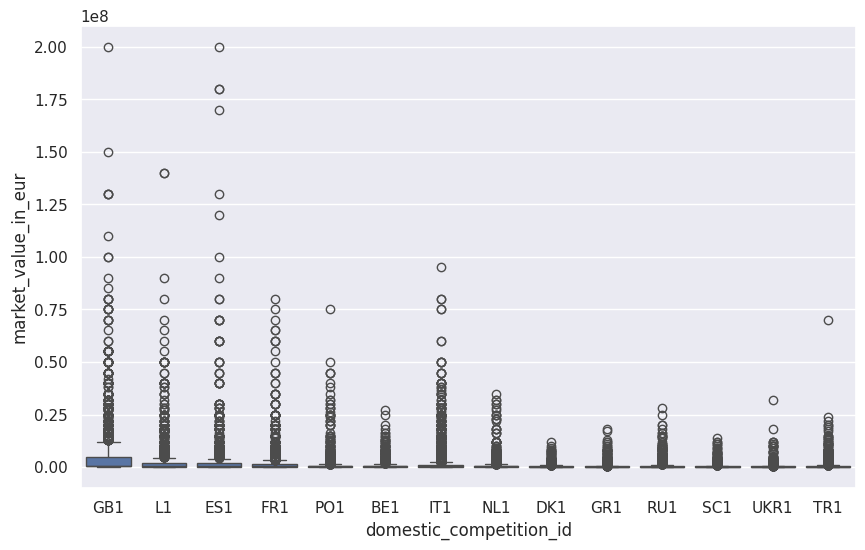

In [18]:
grouped = players.loc[:, ['domestic_competition_id', 'market_value_in_eur']] \
    .groupby(['domestic_competition_id']) \
    .median() \
    .sort_values(by='market_value_in_eur', ascending=False)

sns.set(rc={'figure.figsize':(10,6)})
sns.boxplot(x=players.domestic_competition_id, y=players.market_value_in_eur, order=grouped.index)

<Axes: xlabel='position', ylabel='market_value_in_eur'>

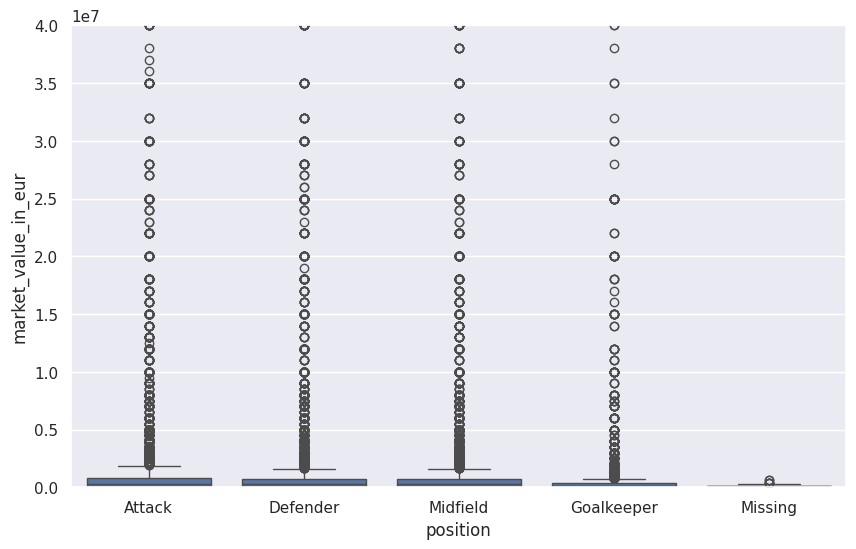

In [19]:
grouped = players.loc[:, ['position', 'market_value_in_eur']] \
    .groupby(['position']) \
    .median() \
    .sort_values(by='market_value_in_eur', ascending=False)

sns.set(rc={'figure.figsize':(10,6)})
plt.ylim(0, 40000000)
sns.boxplot(x=players.position, y=players.market_value_in_eur, order=grouped.index)

По графикам выше видно, что для всех лиг и позиций в выборке есть чудовищное количество выбросов.

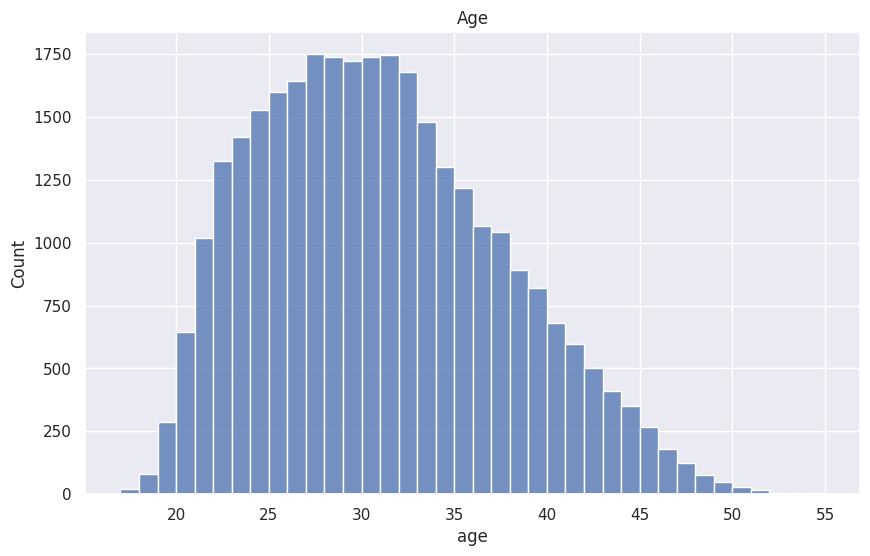

Mean player age :  30.530019970366553
Median player age :  30.0


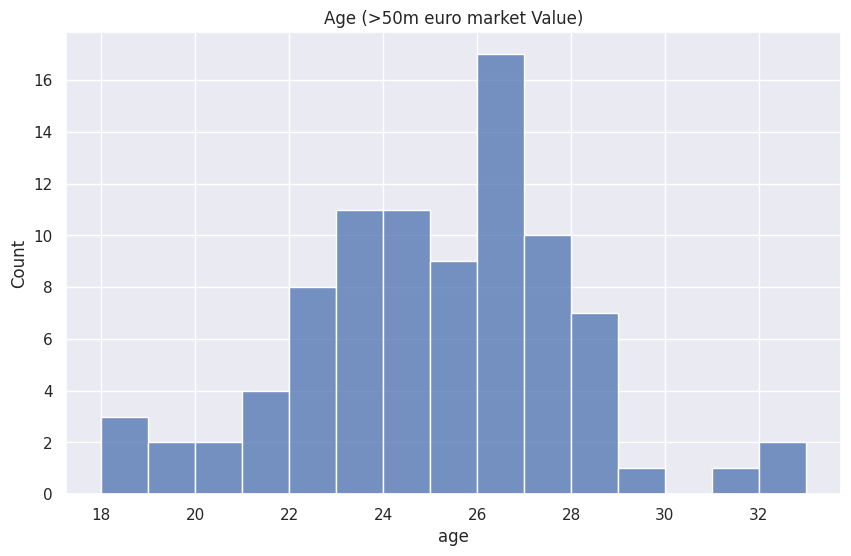

Mean player age (High value) :  24.625
Median player age (High value) :  25.0


In [20]:
plt.title('Age')
sns.histplot(x='age', data=players, binwidth=1)
plt.show()

print("Mean player age : ", players['age'].mean())
print("Median player age : ", players['age'].median())

high_value_players = players[players['market_value_in_eur']>50000000]
plt.title("Age (>50m euro market Value)")
sns.histplot(x='age',data=high_value_players, binwidth=1)
plt.show()

print("Mean player age (High value) : ", high_value_players['age'].mean())
print("Median player age (High value) : ", high_value_players['age'].median())

Видим, что возраст сильно влияет на цену игрока.

One-hot-энкодим позицию игрока на поле (4 уникальных значения) и ведущую ногу игрока.

In [21]:
players = pd.get_dummies(players, columns=['position'])
players = pd.get_dummies(players, columns=['foot'])

Убираем лишний шум, группируя непопулярные страны в категорию Other. Разделяем датасет на обучающую и тестовую выборки. Квантилями срубаем самые края хвостов - они негативно влияют на результаты регрессии в силу особенностей распределения.

Кроме того, логарифмируем цену игрока. Этот трюк мы проделываем, чтобы уменьшить дисперсию фичи и тем самым уточнить предсказание. В конце будем экспоненцировать предсказания, чтобы получить их в той же мере - евро

In [22]:
top_n = 30
for col in ['country_of_citizenship', 'country_of_birth']:
    top_categories = players[col].value_counts().nlargest(top_n).index
    players[col] = players[col].where(players[col].isin(top_categories), 'Other')

train, test = train_test_split(players, test_size=0.2, random_state=50)

q_hi = train['market_value_in_eur'].quantile(0.99)
q_lo = train['market_value_in_eur'].quantile(0.01)
train = train[(train['market_value_in_eur'] >= q_lo) & (train['market_value_in_eur'] <= q_hi)]

train['market_value_in_eur'] = np.log1p(train['market_value_in_eur'])

targets = train['market_value_in_eur'].values

Разделяем обучающую выборку на бины по цене игрока. Делаем разбиение для кросс-валидации. Учим

In [24]:
bins = pd.qcut(train['market_value_in_eur'], q=5, labels=False)
cv = StratifiedKFold(n_splits=5, random_state=100, shuffle=True)
trained = np.zeros(len(train))
oof = np.zeros(len(train))

for fold_, (train_idx, val_idx) in enumerate(cv.split(train, bins), 1):
    print(f'Training with fold {fold_} started')

    cat_features = ['current_club_id', 'domestic_competition_id', 'country_of_citizenship', 'country_of_birth']

    model = cb.CatBoostRegressor(
      iterations=1000,
      learning_rate=0.05,
      depth=8,
      eval_metric='RMSE',
      cat_features=cat_features,
      verbose=100)

    train_, val = train.iloc[train_idx].copy(), train.iloc[val_idx].copy()

    feat_cols = list(train.columns.values)
    feat_cols.remove('market_value_in_eur')

    model.fit(train[feat_cols], train['market_value_in_eur'],
          eval_set=(val[feat_cols], val['market_value_in_eur']),
          early_stopping_rounds=50)

    trained[train_idx] = model.predict(train_[feat_cols])

    oof[val_idx] = model.predict(val[feat_cols])

true = np.expm1(targets)
pred = np.expm1(trained)
pred_oof = np.expm1(oof)

rmsle = mean_squared_log_error(true, pred) ** 0.5
rmsle_oof = mean_squared_log_error(true, pred_oof) ** 0.5

print('Train MAE: ', mean_absolute_error(true, pred))
print('CV MAE: ', mean_absolute_error(true, pred_oof), '\n')
print('Train MAPE: ', mean_absolute_percentage_error(true, pred))
print('CV MAPE: ', mean_absolute_percentage_error(true, pred_oof), '\n')
print('TRAIN RMSLE: ', rmsle)
print('CV RMSLE: ', rmsle_oof)

val_df = pd.DataFrame({
    'true': true,
    'pred': pred_oof
})


val_df['quantile'] = pd.qcut(val_df['true'], q=5)

for q, group in val_df.groupby('quantile'):
    print(f"\n{q}:")
    print("  MAE: ", mean_absolute_error(group['true'], group['pred']))
    print("  MAPE:", mean_absolute_percentage_error(group['true'], group['pred']))

Training with fold 1 started
0:	learn: 1.4269168	test: 1.4229985	best: 1.4229985 (0)	total: 126ms	remaining: 2m 5s
100:	learn: 0.7822948	test: 0.7754802	best: 0.7754802 (100)	total: 4.53s	remaining: 40.3s
200:	learn: 0.7470448	test: 0.7444886	best: 0.7444886 (200)	total: 9.99s	remaining: 39.7s
300:	learn: 0.7205486	test: 0.7217704	best: 0.7217704 (300)	total: 14.3s	remaining: 33.3s
400:	learn: 0.7009560	test: 0.7066177	best: 0.7066177 (400)	total: 18.8s	remaining: 28.1s
500:	learn: 0.6853949	test: 0.6946348	best: 0.6946348 (500)	total: 24.1s	remaining: 24s
600:	learn: 0.6707128	test: 0.6832250	best: 0.6832233 (599)	total: 28.3s	remaining: 18.8s
700:	learn: 0.6580811	test: 0.6733716	best: 0.6733716 (700)	total: 33.9s	remaining: 14.5s
800:	learn: 0.6474968	test: 0.6654476	best: 0.6654476 (800)	total: 38.2s	remaining: 9.5s
900:	learn: 0.6369254	test: 0.6578498	best: 0.6578498 (900)	total: 42.6s	remaining: 4.68s
999:	learn: 0.6275063	test: 0.6510610	best: 0.6510610 (999)	total: 48.1s	remai

<ipython-input-24-8dd64c170e08>:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for q, group in val_df.groupby('quantile'):
